# Install, Import Package

In [1]:
!pip install opencv-contrib-python==4.4.0.44

     |████████████████████████████████| 55.7 MB 45 kB/s 
  Attempting uninstall: opencv-contrib-python
    Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd '/content/drive/MyDrive/Programing (E:)/Nhập Môn CV/Team/Mid-Term Report'

/content/drive/.shortcut-targets-by-id/1uJ336XEgQYZ4EctzzIjrNI5gtBJPe6QE/Team/Mid-Term Report


In [4]:
# import the necessary packages
from __future__ import print_function
import cv2
import imutils

import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
from os.path import join
from os import listdir
from translate import translate

import warnings
warnings.filterwarnings('ignore')

# Prepare dataset

In [12]:
source_data = './data/animals10'
des_weight = '/content/drive/MyDrive/Programing (E:)/Nhập Môn CV/Weight_10Classes'

data_set = listdir(source_data)
class_names = listdir(join(source_data, data_set[0]))
class_names_translated = [translate[x] for x in class_names]

In [ ]:
img_paths = []
labels = []

for st in data_set:
    for i, cls in enumerate(class_names):
        s = os.path.join(source_data, st, cls)
        for path in os.listdir(s):
            img_paths.append(os.path.join(s, path))
            labels.append(i)

labels = np.array(labels)

# with open(join(des_weight, 'labels.npy'), 'wb') as f:
#     np.save(f, labels)

# Visualize data

In [ ]:
def img_show(imgs, labels):
    num_img = len(imgs)
    # plt.figure(figsize=(20*num_img, 20))
    fig, ax = plt.subplots(1, num_img, figsize=(7*num_img, 7))
    # fig.figsize = (20*num_img, 20)
    for i, img in enumerate(imgs):
        # img = np.clip(img, 0, 1)
        ax[i].axis('off')
        ax[i].imshow(img)
        ax[i].set_title(labels[i])
      

    plt.show()

In [6]:
import pandas as pd
import seaborn as sns
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
mpl.style.use('seaborn')

def draw_cf_matrix(cf_matrix, classes):
    sum = cf_matrix.sum()
    cf_matrix = cf_matrix * 1000.0 / ( 1.0 * sum )

    df_cm = pd.DataFrame(cf_matrix, 
    index = classes,
    columns = classes)

    fig = plt.figure()
    plt.clf()

    ax = fig.add_subplot(111)
    ax.set_aspect(1)

    cmap = sns.cubehelix_palette(light=1, as_cmap=True)
    res = sns.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='.2f', cmap=cmap)
    # res.invert_yaxis()
    plt.yticks(ticks=list(range(len(classes))), labels=classes, va='center')
    plt.title('Confusion Matrix')

    plt.show()

# Calculate keypoints for each image and keypoints set

In [ ]:
def CalcFeatures(img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return des

In [ ]:
keypoints = []
for img_path in img_paths:
    img = cv2.imread(img_path, 0) # read image with gray scale
    img_des = CalcFeatures(img) # Calculate keypoints for image
    if img_des is not None:
        keypoints.append(img_des)
features = np.vstack(keypoints)
keypoints = np.array(keypoints)

with open(join(des_weight, 'features.npy'), 'wb') as f:
    np.save(f, features)

with open(join(des_weight, 'keypoints.npy'), 'wb') as f:
    np.save(f, keypoints)

# Using KMeans to clustering keypoints set to a fixed K

In [ ]:
k = 1000
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
flags = cv2.KMEANS_RANDOM_CENTERS
_, _, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

with open(join(des_weight, 'centres' + str(k) + '.npy'), 'wb') as f:
    np.save(f, centres)

# Mapping data to cluster features space

In [ ]:
def bag_of_features(features, centres, k = 1000):
    vec = np.zeros((1, k))
    for i in range(features.shape[0]):
        feat = features[i]
        diff = np.tile(feat, (k, 1)) - centres
        dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
        idx_dist = dist.argsort()
        idx = idx_dist[0]
        vec[0][idx] += 1
    return vec

In [ ]:
vec = []
for des in keypoints:
    img_vec = bag_of_features(des, centres, k)
    vec.append(img_vec)
vec = np.vstack(vec)

with open(join(des_weight, 'vec' + str(k) + '.npy'), 'wb') as f:
    np.save(f, vec)

# Load pretrained weight

In [5]:
source_weight = '/content/drive/MyDrive/Programing (E:)/Nhập Môn CV/Weight_10Classes'

with open(join(source_weight, 'features.npy'), 'rb') as f:
    features = np.load(f, allow_pickle=True)

with open(join(source_weight, 'keypoints.npy'), 'rb') as f:
    keypoints = np.load(f, allow_pickle=True)

with open(join(source_weight, 'labels.npy'), 'rb') as f:
    labels = np.load(f, allow_pickle=True)

with open(join(source_weight, 'centres1000.npy'), 'rb') as f:
    centres = np.load(f, allow_pickle=True)

with open(join(source_weight, 'vec1000.npy'), 'rb') as f:
    vec = np.load(f, allow_pickle=True)

# Test model

In [ ]:
imgs = []
features = []
y = []

for i, img_path in enumerate(img_paths[:10]):
    img = plt.imread(img_path)
    imgs.append(img)
    features.append(vec[i])

imgs = np.array(imgs)
features = np.array(features)
y = np.array(y)

y_pred = svm_model.predict(features)

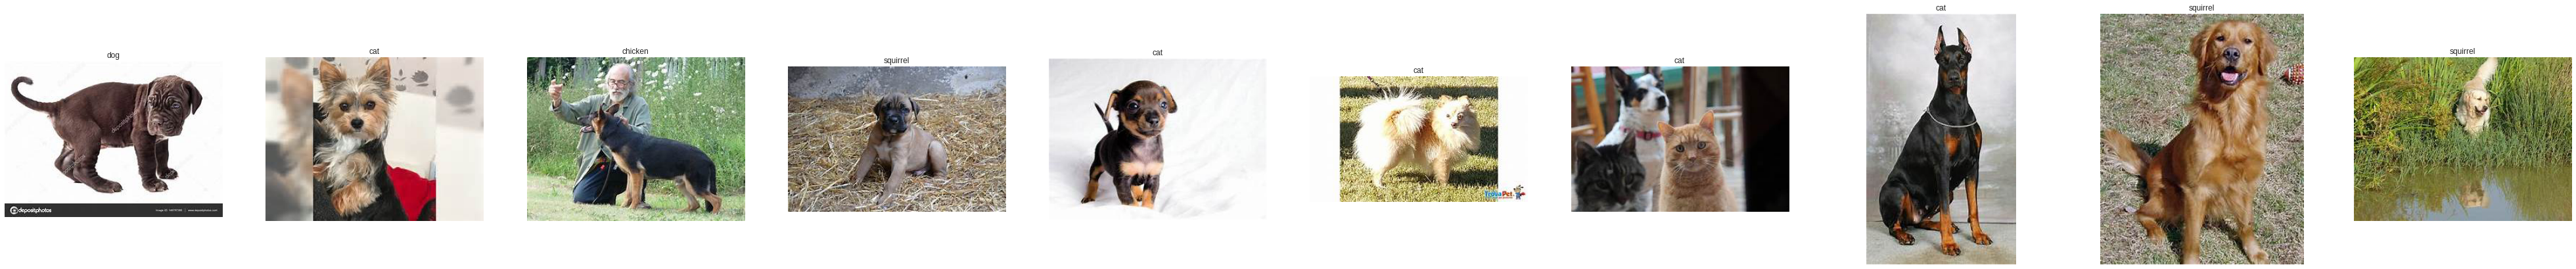

In [ ]:
img_show(imgs, [class_names_translated[x] for x in y_pred])

# SVM rbf

In [7]:
X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
svm_model = SVC(kernel='rbf')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [9]:
y_pred = svm_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [10]:
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.39357142857142857
Recall:  0.39357142857142857
Precision:  0.39357142857142857
F1:  0.3935714285714285


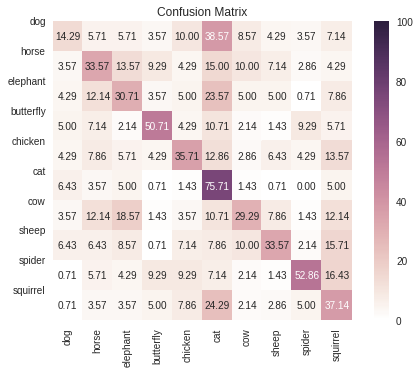

In [13]:
draw_cf_matrix(conf_mat, class_names_translated)

# SVM linear

In [14]:
X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [15]:
y_pred = svm_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [16]:
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.35714285714285715
Recall:  0.35714285714285715
Precision:  0.35714285714285715
F1:  0.35714285714285715


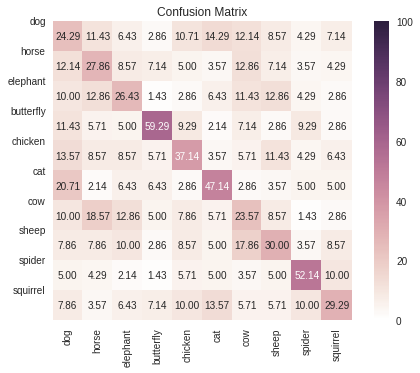

In [17]:
draw_cf_matrix(conf_mat, class_names_translated)

# SVM poly

In [18]:
X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
svm_model = SVC(kernel='poly')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [19]:
y_pred = svm_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [20]:
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.10357142857142858
Recall:  0.10357142857142858
Precision:  0.10357142857142858
F1:  0.10357142857142858


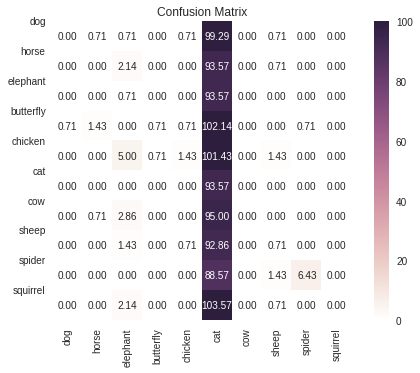

In [21]:
draw_cf_matrix(conf_mat, class_names_translated)

# SVM sigmoid

In [22]:
X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
svm_model = SVC(kernel='sigmoid')
svm_model.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [23]:
y_pred = svm_model.predict(X_test)
conf_mat = confusion_matrix(y_test, y_pred)

In [24]:
print('Accuracy: ', accuracy_score(y_pred, y_test))
print('Recall: ',recall_score(y_pred, y_test,average='micro'))
print('Precision: ',precision_score(y_pred, y_test,average='micro'))
print('F1: ',f1_score(y_pred, y_test,average='micro'))

Accuracy:  0.32142857142857145
Recall:  0.32142857142857145
Precision:  0.32142857142857145
F1:  0.32142857142857145


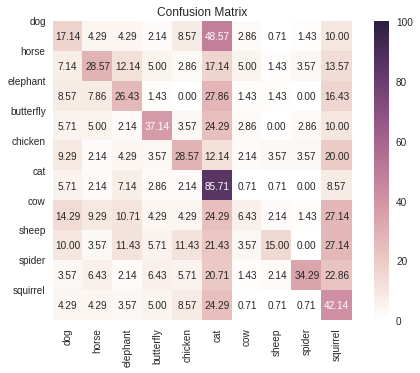

In [25]:
draw_cf_matrix(conf_mat, class_names_translated)